In [1]:
from idaes import __version__

if '2.0.0.a3' not in __version__:
    raise EnvironmentError("This notebook requires the 2.0.0.a3 pre-release of idaes-pse, which can be found here: https://github.com/dguittet/idaes-pse/tree/2.0.0.a3")

from wind_battery_double_loop import MultiPeriodWindBattery
from dispatches_sample_data import rts_gmlc
from double_loop_utils import *

## Creating the Co-simulation of the Wind and Battery IES within the Production Cost Model with Bidder and Tracker Models

In the [Conceptual Design Optimization Example Notebook](./ConceptualDesignOptimization.ipynb), the design of a Wind + Battery + Hydrogen integrated energy system was optimized using the RTS-GMLC outputs with a "price taker" assumption. Here, we take one of the possible results, a Wind + Battery IES with no Hydrogen, and evaluate its performance in an electricity market by co-simulating its bidding and operation decisions within the production cost model, Prescient, in a "double-loop" optimization.

This double-loop is performed by embedding the multiperiod Wind + Battery flowsheet model as a `MultiPeriodWindBattery` within a `Bidder` and a `Tracker` model, whose functions are to optimize the Day-ahead or Real-time energy market bids, and to optimize the operation of the IES to follow the cleared market's dispatch, respectively. These functions are coordinated in order and with the correct data transfers with Prescient by a `DoubleLoopCoordinator` class. Prescient is then able to evaluate the economic performance of the designed IES within the grid with market interactions and forecast uncertainty. The steps are as shown in this diagram:

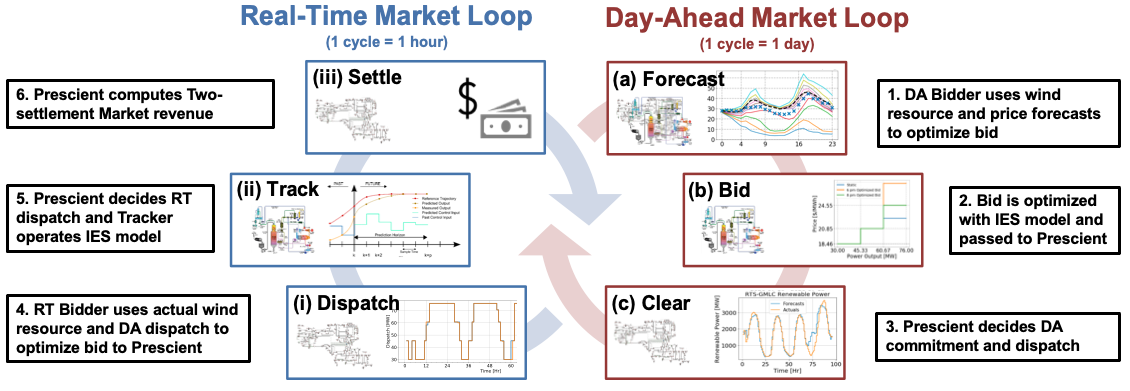

In the Day-ahead loop, the Unit Commitment Problem is solved by forecasting loads and obtaining generator bids, and produces hourly schedules and LMPs. The `Bidder` will use forecasts and plant information to optimize the DA bid to Prescient.

In the Real-time loop, the Economic Dispatch Problem is solved using real-time loads and resources to produce updated generator dispatch points and commitments. The `Bidder` will use forecasts, DA dispatch and prices, and plant information to optimize the updated RT bid. Once the Real-time market is cleared, the `Tracker` controls the IES to implement the dispatch at lowest cost. 

The market participants are paid on energy and/or reserve provided based on the two-settlement system:

$$R = Q_{DA} \times P_{DA} + (Q_{RT} - Q_{DA}) \times P_{RT}$$

where $R$ is revenue, $Q_{DA}$ is power sold to DA market at $P_{DA}$ price, and $Q_{RT}$ is power delivered to RT market at $P_{RT}$ price.

First, we define the electricity grid for the double-loop simulation via options to Prescient: the directory to the RTS-GMLC source data, the time horizons for the UC and ED problems, the start date and length of the simulation, how much reserves should be procured, etc. The full-year PCM simulation was completed prior and the outputs were collected into a `Wind_Thermal_Dispatch.csv` in order to provide "historical" LMPs and Wind resource capacity factors for the Conceptual Design Optimization.

In this example, we will repeat the Prescient simulation with no reserves for a single week, where the Wind + Battery IES will replace the `309_WIND_1` Wind plant at the "Carter" bus.

In [2]:
from prescient.simulator import Prescient
import os

start_date = "01-02-2020"
sim_days = 7
day_ahead_horizon = 48
real_time_horizon = 4
output_dir = Path(f"double_loop_results")

wind_bus = 309
wind_bus_name = "Carter"
wind_generator = f"{wind_bus}_WIND_1"

milp_solver = 'xpress_direct'

prescient_options = {
    "data_path": rts_gmlc.source_data_path,
    "input_format": "rts-gmlc",
    "simulate_out_of_sample": True,
    "run_sced_with_persistent_forecast_errors": True,
    "output_directory": output_dir,
    "start_date": start_date,
    "num_days": sim_days,
    "sced_horizon": real_time_horizon,
    "ruc_horizon": day_ahead_horizon,
    "compute_market_settlements": True,
    "day_ahead_pricing": "LMP",
    "ruc_mipgap": 0.05,
    "symbolic_solver_labels": True,
    "reserve_factor": 0,
    "deterministic_ruc_solver": milp_solver,
    "sced_solver": milp_solver,
    "plugin": {
        "doubleloop": {
            "module": None,                                          # to be added below
            "bidding_generator": wind_generator,
        }
    }
}

# collect "historical" full-year wind forecast and first-day LMPs
prescient_outputs_df = pd.read_csv(Path(os.path.realpath("__file__")).parent / "data" / "Wind_Thermal_Dispatch.csv")
prescient_outputs_df.index = pd.to_datetime(prescient_outputs_df['Unnamed: 0'])
prescient_outputs_df = prescient_outputs_df[prescient_outputs_df.index >= pd.Timestamp(f'{start_date} 00:00:00')]
gen_capacity_factor = prescient_outputs_df[f"{wind_generator}-RTCF"].values.tolist()
historical_da_prices = {
    wind_bus_name: prescient_outputs_df[f"{wind_bus}_DALMP"].values[0:24].tolist()
}
historical_rt_prices = {
    wind_bus_name: prescient_outputs_df[f"{wind_bus}_RTLMP"].values[0:24].tolist()
}

Interactive Python mode detected; using default matplotlib backend for plotting.


## Creating the IES Generator within the RTS-GMLC

First, the location, type, capacity, and other parameters of the IES needs to be defined in order to situate the generator within the electricity market. In this example, the IES' bid will be represented as that of a thermal generator, with parameters such as min power, max power, ramping constraints, startup and shutdown capacity, even though the IES will not need them all. The wind resource at the chosen location, at the "Carter" bus, is read from the RTS-GMLC Source Data.

The information is passed to the `MultiPeriodWindBattery` class, which enables the `Bidder` and `Tracker` to construct a Wind + Battery multiperiod model within its bidding and tracking optimization problems via `populate_model`, and to update the state of the Wind + Battery IES as the double-loop steps forward in time via `update_model`.

In [3]:
from idaes.apps.grid_integration.model_data import ThermalGeneratorModelData

p_min = 0
wind_pmax = 147.6
battery_pmax = 25
battery_emax = battery_pmax * 4

# for descriptions on what each parameter means, see `help(ThermalGeneratorModelData)`
thermal_generator_params = {
    "gen_name": wind_generator,
    "bus": wind_bus_name,
    "p_min": p_min,
    "p_max": wind_pmax,
    "min_down_time": 0,
    "min_up_time": 0,
    "ramp_up_60min": wind_pmax + battery_pmax,
    "ramp_down_60min": wind_pmax + battery_pmax,
    "shutdown_capacity": wind_pmax + battery_pmax,
    "startup_capacity": 0,
    "initial_status": 1,
    "initial_p_output": 0,
    "production_cost_bid_pairs": [(p_min, 0), (wind_pmax, 0)],
    "startup_cost_pairs": [(0, 0)],
    "fixed_commitment": None,
}
model_data = ThermalGeneratorModelData(**thermal_generator_params)

mp_wind_battery_bid = MultiPeriodWindBattery(
    model_data=model_data,
    wind_capacity_factors=gen_capacity_factor,
    wind_pmax_mw=wind_pmax,
    battery_pmax_mw=battery_pmax,
    battery_energy_capacity_mwh=battery_emax,
)

## Creating the Forecaster, Tracker, and Bidder for the DoupleLoopCoordinator

The `Bidder` requires a forecast of the DA and RT prices in order to plan out its energy bid: at what time to sell how much energy and at what price, given the anticipated wind resource and the evolution of the battery state-of-charge. In contrast to the price-taker assumption in the Conceptual Design phase where the Wind + Battery IES took the historical LMPs for however much energy it sold, here, the `Bidder` does not know what the final LMP will be, nor that its bid for energy at a certain marginal cost will be accepted by the market. 

The `Backcaster` class stores historical DA and RT LMPs in order to generate forecast scenarios. The first day of simulated DA and RT LMPs initializes the `Backcaster`, which continues to collect resolved LMPs as the simulation steps forward in time. 

Within the `DoubleLoopCoordinator`, there are two `Tracker` objects, the first `tracker` follows the real-time market signals whereas the second `projection_tracker` projects the latest real-time dispatch onto the next day-ahead bidding problem. 

In [4]:
import pyomo.environ as pyo
from idaes.apps.grid_integration.forecaster import Backcaster
from idaes.apps.grid_integration import Tracker, DoubleLoopCoordinator, Bidder

# Backcaster
help(Backcaster)
backcaster = Backcaster(historical_da_prices, historical_rt_prices)

Help on class Backcaster in module idaes.apps.grid_integration.forecaster:

class Backcaster(AbstractPrescientPriceForecaster)
 |  Backcaster(historical_da_prices, historical_rt_prices, max_historical_days=10)
 |  
 |  Generate price forecasts by directly using historical prices.
 |  
 |  Method resolution order:
 |      Backcaster
 |      AbstractPrescientPriceForecaster
 |      AbstractPriceForecaster
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, historical_da_prices, historical_rt_prices, max_historical_days=10)
 |      Initialize the Backcaster.
 |      
 |      Arguments:
 |          historical_da_prices: dictionary of list for historical hourly day-ahead prices
 |      
 |          historical_rt_prices: dictionary of list for historical hourly real-time prices
 |      
 |          max_historical_days: maximum number of days of price data to store on the instance
 |      
 |      Returns:
 |          None
 |  
 |  fetch_day_ahead_st

In [5]:
n_price_scenario = 3
solver = pyo.SolverFactory(milp_solver)

# Bidder
help(Bidder)
bidder_mp_wind_battery = MultiPeriodWindBattery(
    model_data=model_data,
    wind_capacity_factors=gen_capacity_factor,
    wind_pmax_mw=wind_pmax,
    battery_pmax_mw=battery_pmax,
    battery_energy_capacity_mwh=battery_emax,
)

bidder_object = Bidder(
    bidding_model_object=bidder_mp_wind_battery,
    day_ahead_horizon=day_ahead_horizon,
    real_time_horizon=real_time_horizon,
    n_scenario=n_price_scenario,
    solver=solver,
    forecaster=backcaster,
)

Help on class Bidder in module idaes.apps.grid_integration.bidder:

class Bidder(StochasticProgramBidder)
 |  Bidder(bidding_model_object, day_ahead_horizon, real_time_horizon, n_scenario, solver, forecaster)
 |  
 |  Wrap a model object to bid into the market using stochastic programming.
 |  
 |  Method resolution order:
 |      Bidder
 |      StochasticProgramBidder
 |      AbstractBidder
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, bidding_model_object, day_ahead_horizon, real_time_horizon, n_scenario, solver, forecaster)
 |      Initializes the bidder object.
 |      
 |      Arguments:
 |          bidding_model_object: the model object for bidding
 |      
 |          day_ahead_horizon: number of time periods in the day-ahead bidding problem
 |      
 |          real_time_horizon: number of time periods in the real-time bidding problem
 |      
 |          n_scenario: number of uncertain LMP scenarios
 |      
 |          solver: 

In [6]:
tracking_horizon = 4
n_tracking_hour = 1

# Tracker
help(Tracker)
tracker_mp_wind_battery = MultiPeriodWindBattery(
    model_data=model_data,
    wind_capacity_factors=gen_capacity_factor,
    wind_pmax_mw=wind_pmax,
    battery_pmax_mw=battery_pmax,
    battery_energy_capacity_mwh=battery_emax,
)

tracker_object = Tracker(
    tracking_model_object=tracker_mp_wind_battery,
    tracking_horizon=tracking_horizon,
    n_tracking_hour=n_tracking_hour,
    solver=solver,
)

# Projection Tracker
projection_mp_wind_battery = MultiPeriodWindBattery(
    model_data=model_data,
    wind_capacity_factors=gen_capacity_factor,
    wind_pmax_mw=wind_pmax,
    battery_pmax_mw=battery_pmax,
    battery_energy_capacity_mwh=battery_emax,
)

projection_tracker_object = Tracker(
    tracking_model_object=projection_mp_wind_battery,
    tracking_horizon=tracking_horizon,
    n_tracking_hour=n_tracking_hour,
    solver=solver,
)

Help on class Tracker in module idaes.apps.grid_integration.tracker:

class Tracker(builtins.object)
 |  Tracker(tracking_model_object, tracking_horizon, n_tracking_hour, solver)
 |  
 |  Wrap a model object to track the market dispatch signals. This class interfaces
 |  with the DoubleLoopCoordinator.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, tracking_model_object, tracking_horizon, n_tracking_hour, solver)
 |      Initializes the tracker object.
 |      
 |      Arguments:
 |          tracking_model_object: the model object for tracking
 |      
 |          tracking_horizon: number of time periods in the tracking problem
 |      
 |          n_tracking_hour: number of implemented hours after each solve
 |      
 |          solver: a Pyomo mathematical programming solver object
 |      
 |      Returns:
 |          None
 |  
 |  formulate_tracking_problem(self)
 |      Formulate the tracking optimization problem by adding necessary
 |      parameters, constraints, and obj

In [7]:
# Compose into Coordinator
help(DoubleLoopCoordinator)
coordinator = DoubleLoopCoordinator(
    bidder=bidder_object,
    tracker=tracker_object,
    projection_tracker=projection_tracker_object,
)

Help on class DoubleLoopCoordinator in module idaes.apps.grid_integration.coordinator:

class DoubleLoopCoordinator(builtins.object)
 |  DoubleLoopCoordinator(bidder, tracker, projection_tracker)
 |  
 |  Coordinate Prescient, tracker and bidder.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, bidder, tracker, projection_tracker)
 |      Initializes the DoubleLoopCoordinator object and registers functionalities
 |      in Prescient's plugin system.
 |      
 |      Arguments:
 |          bidder: an initialized bidder object
 |      
 |          tracker: an initialized tracker object
 |      
 |          projection_tracker: an initialized tracker object, this object is
 |                              mimicking the behaviror of the projection SCED in
 |                              Prescient and to projecting the system states
 |                              and updating bidder model.
 |      
 |      Returns:
 |          None
 |  
 |  activate_pending_DA_data(self, options, simul

## Running the Double-Loop Plugin

The prescient_options are updated with the DoubleLoopCoordinator. The simulation results will be written to the `output_dir` folder.

In [8]:
from types import ModuleType
import shutil

class PrescientPluginModule(ModuleType):
    def __init__(self, get_configuration, register_plugins):
        self.get_configuration = get_configuration
        self.register_plugins = register_plugins


plugin_module = PrescientPluginModule(
    get_configuration=coordinator.get_configuration,
    register_plugins=coordinator.register_plugins,
)

prescient_options['plugin']['doubleloop']['module'] = plugin_module

if output_dir.exists():
    shutil.rmtree(output_dir)
    
Prescient().simulate(**prescient_options)

Initializing simulation...
Did not find reserves.csv; assuming no reserves


/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/pandas/io/parsers/base_parser.py:1055: FutureWarning: 
        Use pd.to_datetime instead.

  return generic_parser(date_parser, *date_cols)


Setting default t0 state in RTS-GMLC parser
Dates to simulate: 2020-01-02 to 2020-01-08
RUC activation hours: 0
Final RUC date: 2020-01-08
Using current day's forecasts for RUC solves
Using persistent forecast error model when projecting demand and renewables in SCED


Extracting scenario to simulate
FICO Xpress v8.12.4, Hyper, solve started 10:09:57, Jul 4, 2022
Heap usage: 1540KB (peak 1540KB, 1449KB system)
Maximizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
      2586 rows         2016 cols         4443 elements
Presolved problem has:
       429 rows          576 cols         1431 elements
Presolve finished in 0 seconds
Heap usage: 1574KB (peak 2983KB, 1451KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 7.71e+02,  1.00e+08] / [ 7.71e+02,  8.00e+08]
  Objective      [min,max] : [ 1.50e-02,  1.89e+01] /


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:12:55, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2798KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         9 rows           14 cols           32 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2801KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 4.15e+02,  1.00e+08] / [ 3.95e+02,  2.00e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.20e-01,  2.00e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 2 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       3970.847531      D      4     0        .000000     0
     4       4415.440756      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:13:00, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2826KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         6 rows           10 cols           26 elements
Presolve finished in 0 seconds
Heap usage: 360KB (peak 402KB, 2829KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 5.00e-05,  1.05e+00]
  RHS and bounds [min,max] : [ 3.27e+03,  1.00e+08] / [ 3.27e+03,  1.00e+05]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  1.00e+01]
Autoscaling applied standard scaling

 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       2922.590958      D      3     0        .000000     0
     3       3200.896083      D      0     0        .000000     0
Uncrunching matrix
Optim


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:13:06, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2854KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         6 rows           10 cols           26 elements
Presolve finished in 0 seconds
Heap usage: 360KB (peak 402KB, 2857KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 5.00e-05,  1.05e+00]
  RHS and bounds [min,max] : [ 9.21e+02,  1.00e+08] / [ 9.21e+02,  1.00e+05]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  1.00e+01]
Autoscaling applied standard scaling

 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       2904.986945      D      3     0        .000000     0
     3       2944.424909      D      0     0        .000000     0
Uncrunching matrix
Optim


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:13:11, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2883KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         6 rows           10 cols           26 elements
Presolve finished in 0 seconds
Heap usage: 360KB (peak 402KB, 2885KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 5.00e-05,  1.05e+00]
  RHS and bounds [min,max] : [ 7.71e+02,  1.00e+08] / [ 7.71e+02,  1.00e+05]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  1.00e+01]
Autoscaling applied standard scaling

 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       2905.360175      D      3     0        .000000     0
     3       2924.705927      D      0     0        .000000     0
Uncrunching matrix
Optim


User solution (_) stored.

Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:13:17, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2913KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         8 rows           14 cols           33 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2915KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.28e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 1.80e+00,  1.00e+08] / [ 4.61e+02,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 4.80e-01,  2.00e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 2 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       2908.532625      D      5     0        .000000     0
     6  

FICO Xpress v8.12.4, Hyper, solve started 10:13:36, Jul 4, 2022
Heap usage: 1457KB (peak 1694KB, 10MB system)
Maximizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
      2586 rows         2016 cols         4712 elements
Presolved problem has:
       422 rows          565 cols         1426 elements
Presolve finished in 0 seconds
Heap usage: 1630KB (peak 3034KB, 10MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  2.34e+01] / [ 1.28e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 9.00e+02,  1.00e+08] / [ 9.00e+02,  1.02e+08]
  Objective      [min,max] : [ 1.50e-02,  2.37e+01] / [ 6.15e-03,  1.69e-01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 49 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       193513.8097      D    276     0        .000000     0
   366       140128.2206      P      0     0        .0


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:14:40, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2764KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         8 rows           15 cols           35 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2766KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  3.20e+01]
  RHS and bounds [min,max] : [ 2.60e+01,  1.00e+08] / [ 5.06e+02,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 4.80e-01,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 1 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       23826.98475      D      4     0        .000000     0
     5       24154.68079      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:14:46, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2792KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         9 rows           14 cols           32 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2794KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 2.50e+04,  1.00e+08] / [ 1.25e+04,  2.00e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.20e-01,  2.00e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 2 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       124792.4601      D      4     0        .000000     0
     4       125354.9601      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:14:52, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2820KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         9 rows           14 cols           32 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2822KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 3.73e+00,  1.00e+08] / [ 1.86e+00,  2.00e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.20e-01,  2.00e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 2 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       126053.1479      D      4     0        .000000     0
     4       126615.6479      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:14:57, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2848KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        11 rows           18 cols           39 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2851KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  8.42e+00]
  RHS and bounds [min,max] : [ 8.27e+01,  1.00e+08] / [ 5.29e+03,  2.00e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 3 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       116636.3155      D      4     0        .000000     0
     5       117198.8306      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:15:03, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2876KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        10 rows           17 cols           37 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2879KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  8.42e+00]
  RHS and bounds [min,max] : [ 7.61e+01,  1.00e+08] / [ 4.87e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 2 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       96852.22919      D      4     0        .000000     0
     5       97414.73379      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:15:09, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2905KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        15 rows           26 cols           53 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2907KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  8.00e+00]
  RHS and bounds [min,max] : [ 3.62e+01,  1.00e+08] / [ 2.32e+03,  1.00e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 5 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       54028.69581      D      5     0        .000000     0
     8       54404.92592      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:15:15, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2933KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        12 rows           22 cols           53 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2935KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.28e-02,  3.20e+01]
  RHS and bounds [min,max] : [ 3.98e+01,  1.00e+08] / [ 2.49e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 7.50e-03,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 3 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       39149.26222      D      6     0        .000000     0
     8       127718.4172      P    


User solution (_) stored.

Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:15:23, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2965KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         8 rows           14 cols           39 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2968KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  6.40e+01]
  RHS and bounds [min,max] : [ 6.35e+01,  1.00e+08] / [ 3.51e-04,  1.02e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 4.96e-01,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 1 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       155316.2698      D      4     0        .000000     0
     6  

FICO Xpress v8.12.4, Hyper, solve started 10:15:43, Jul 4, 2022
Heap usage: 1461KB (peak 1694KB, 10MB system)
Maximizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
      2586 rows         2016 cols         4840 elements
Presolved problem has:
       427 rows          563 cols         1452 elements
Presolve finished in 0 seconds
Heap usage: 1636KB (peak 3050KB, 10MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  3.07e+01] / [ 5.00e-05,  1.95e+00]
  RHS and bounds [min,max] : [ 2.38e+04,  1.00e+08] / [ 2.92e-03,  1.00e+05]
  Objective      [min,max] : [ 1.50e-02,  3.45e+01] / [ 1.14e-02,  3.45e+01]
Autoscaling applied standard scaling

Crash basis containing 51 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       333097.6110      D    274     0        .000000     0
   333       278886.6424      D      0     0        .0000


FICO Xpress v8.12.4, Hyper, solve started 10:17:56, Jul 4, 2022
Heap usage: 412KB (peak 412KB, 3137KB system)
Maximizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
       198 rows          168 cols          376 elements
Presolved problem has:
        32 rows           42 cols          146 elements
Presolve finished in 0 seconds
Heap usage: 409KB (peak 525KB, 3140KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 5.60e-08,  1.05e+00] / [ 5.00e-05,  1.05e+00]
  RHS and bounds [min,max] : [ 2.50e+04,  1.00e+08] / [ 7.02e-04,  2.76e+05]
  Objective      [min,max] : [ 1.50e-02,  1.00e+00] / [ 7.50e-03,  1.00e+00]
Autoscaling applied standard scaling

Crash basis containing 1 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       24731.56723      D     21     0        .000000     0
    23       22664.32710      D      0     0        .0000


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:18:07, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2858KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         8 rows           14 cols           39 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2860KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 5.00e-05,  1.05e+00]
  RHS and bounds [min,max] : [ 2.64e+01,  1.00e+08] / [ 7.02e-04,  2.43e+05]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  1.00e+04]
Autoscaling applied standard scaling

 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       17596.31027      D      5     0        .000000     0
    10       88469.98027      D      0     0        .000000     0
Uncrunching matrix
Optim


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:18:14, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2886KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         8 rows           15 cols           35 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2888KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  3.20e+01]
  RHS and bounds [min,max] : [ 3.28e+01,  1.00e+08] / [ 4.20e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 4.80e-01,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 1 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       37020.84854      D      4     0        .000000     0
     6       80833.56950      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:18:20, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2914KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        10 rows           19 cols           42 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2916KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  3.20e+01]
  RHS and bounds [min,max] : [ 5.20e+01,  1.00e+08] / [ 6.25e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 2 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       144315.2771      D      4     0        .000000     0
     9       157966.7871      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:18:28, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2947KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        12 rows           23 cols           49 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2949KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  3.20e+01]
  RHS and bounds [min,max] : [ 1.08e+02,  1.00e+08] / [ 6.25e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 3.00e-02,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 4 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       70450.81313      D      6     0        .000000     0
     7       70825.81147      D    


User solution (_) stored.

Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:18:36, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2750KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        17 rows           30 cols           60 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2752KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  8.00e+00]
  RHS and bounds [min,max] : [ 4.13e+00,  1.00e+08] / [ 2.06e+00,  1.00e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       2898.082189      D     11     0        .000000     0
    16       2937.584725      D      0     0        .000000 


User solution (_) stored.

User solution (_) stored.

Solving for LMPs


User solution (_) stored.

FICO Xpress v8.12.4, Hyper, solve started 10:18:45, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 3075KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        12 rows           21 cols           44 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 3078KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 8.07e+01,  1.00e+08] / [ 1.03e+04,  1.02e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 2.40e-01,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 3 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       163802.


User solution (_) stored.

Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:18:54, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2830KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         9 rows           15 cols           37 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2832KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  3.20e+01]
  RHS and bounds [min,max] : [ 1.40e+02,  1.00e+08] / [ 1.19e+04,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 4.80e-01,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 1 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       334027.0522      D      5     0        .000000     0
     7  

FICO Xpress v8.12.4, Hyper, solve started 10:19:14, Jul 4, 2022
Heap usage: 1461KB (peak 1694KB, 10MB system)
Maximizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
      2586 rows         2016 cols         4852 elements
Presolved problem has:
       435 rows          567 cols         1476 elements
Presolve finished in 0 seconds
Heap usage: 1640KB (peak 3052KB, 10MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  3.25e+01] / [ 5.00e-05,  1.95e+00]
  RHS and bounds [min,max] : [ 2.44e+01,  1.00e+08] / [ 2.44e-03,  1.00e+05]
  Objective      [min,max] : [ 1.50e-02,  3.45e+01] / [ 1.14e-02,  3.45e+01]
Autoscaling applied standard scaling

Crash basis containing 51 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       373357.2603      D    282     0        .000000     0
   337       318744.4636      D      0     0        .0000

FICO Xpress v8.12.4, Hyper, solve started 10:21:39, Jul 4, 2022
Heap usage: 412KB (peak 412KB, 2943KB system)
Maximizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
       198 rows          168 cols          408 elements
Presolved problem has:
        43 rows           54 cols          162 elements
Presolve finished in 0 seconds
Heap usage: 410KB (peak 526KB, 2946KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 5.60e-08,  1.05e+00] / [ 5.00e-05,  1.05e+00]
  RHS and bounds [min,max] : [ 2.50e+04,  1.00e+08] / [ 2.50e+04,  6.35e+05]
  Objective      [min,max] : [ 1.50e-02,  1.00e+00] / [ 7.50e-03,  1.00e+00]
Autoscaling applied standard scaling

Crash basis containing 5 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       53261.34726      D     26     0        .000000     0
    29       47843.17873      D      0     0        .00000


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:21:51, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2944KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        13 rows           22 cols           46 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2947KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  8.42e+00]
  RHS and bounds [min,max] : [ 2.64e+00,  1.00e+08] / [ 1.32e+00,  1.00e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 4 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       243503.2069      D      5     0        .000000     0
     8       303123.5765      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:22:00, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2743KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        15 rows           26 cols           53 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2745KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  8.42e+00]
  RHS and bounds [min,max] : [ 1.45e+02,  1.00e+08] / [ 6.25e+03,  1.00e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 5 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       123789.5185      D      5     0        .000000     0
     8       124049.9173      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:22:08, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2771KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        17 rows           30 cols           60 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2773KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  8.00e+00]
  RHS and bounds [min,max] : [ 1.36e+00,  1.00e+08] / [ 6.80e-01,  1.00e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       2898.082189      D     11     0        .000000     0
    16       114309.9320      D      0     0        .000000     0
Uncrunching matrix
Op


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:22:16, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2799KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        13 rows           22 cols           46 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2801KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  8.42e+00]
  RHS and bounds [min,max] : [ 2.26e+00,  1.00e+08] / [ 1.13e+00,  1.00e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 4 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       242499.6331      D      5     0        .000000     0
     9       242888.2005      D    


Solving for LMPs


User solution (_) stored.

FICO Xpress v8.12.4, Hyper, solve started 10:22:25, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 3118KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        17 rows           30 cols           60 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 3120KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  8.00e+00]
  RHS and bounds [min,max] : [ 1.61e+00,  1.00e+08] / [ 8.05e-01,  1.00e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       2898.082189      D     11     0        .000000     0
    14       3085.619565      D      0     0        .000000 


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:22:34, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2860KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        14 rows           25 cols           51 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2862KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 3.12e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 1.11e+02,  1.00e+08] / [ 1.25e+04,  1.02e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 2.40e-01,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 4 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       122575.3327      D      6     0        .000000     0
    10       122809.2694      D    


User solution (_) stored.

User solution (_) stored.

Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:22:45, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2900KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         8 rows           15 cols           35 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2902KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  3.20e+01]
  RHS and bounds [min,max] : [ 1.44e+02,  1.00e+08] / [ 1.25e+04,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 4.80e-01,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 1 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       363056.0475      D      4     0   

FICO Xpress v8.12.4, Hyper, solve started 10:23:21, Jul 4, 2022
Heap usage: 1461KB (peak 1695KB, 10MB system)
Maximizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
      2586 rows         2016 cols         4860 elements
Presolved problem has:
       456 rows          576 cols         1539 elements
Presolve finished in 0 seconds
Heap usage: 1645KB (peak 3053KB, 10MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  3.33e+01] / [ 5.00e-05,  1.91e+00]
  RHS and bounds [min,max] : [ 2.66e+03,  1.00e+08] / [ 4.44e-03,  1.00e+05]
  Objective      [min,max] : [ 1.50e-02,  3.45e+01] / [ 1.14e-02,  3.45e+01]
Autoscaling applied standard scaling

Crash basis containing 48 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       388314.8030      D    297     0        .000000     0
   351       331572.9204      P      0     0        .0000


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:24:35, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2750KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         6 rows           10 cols           26 elements
Presolve finished in 0 seconds
Heap usage: 360KB (peak 402KB, 2752KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 5.00e-05,  1.05e+00]
  RHS and bounds [min,max] : [ 2.50e+04,  1.00e+08] / [ 2.50e+04,  5.78e+05]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  1.00e+01]
Autoscaling applied standard scaling

 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       482039.8641      D      3     0        .000000     0
     5       557039.8598      D      0     0        .000000     0
Uncrunching matrix
Optim


User solution (_) stored.

Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:24:43, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2787KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         8 rows           14 cols           33 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2790KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  3.20e+01]
  RHS and bounds [min,max] : [ 1.38e+02,  1.00e+08] / [ 6.25e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 1 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       358240.4962      D      3     0        .000000     0
     6  


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:24:51, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2823KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        12 rows           22 cols           53 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2825KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 5.00e-05,  1.05e+00]
  RHS and bounds [min,max] : [ 1.07e+02,  1.00e+08] / [ 4.06e-03,  5.90e+05]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 7.50e-03,  1.00e+04]
Autoscaling applied standard scaling

Crash basis containing 1 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       110303.4767      D      9     0        .000000     0
    10       136883.8806      D      0


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:24:58, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2851KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        14 rows           25 cols           51 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2853KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 3.12e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 3.76e+01,  1.00e+08] / [ 4.81e+03,  1.02e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 2.40e-01,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 4 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       3091.516107      D      6     0        .000000     0
    10       73723.17173      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:25:04, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2879KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        13 rows           22 cols           46 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2881KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  8.42e+00]
  RHS and bounds [min,max] : [ 2.63e+00,  1.00e+08] / [ 1.31e+00,  1.00e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 4 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       220985.0006      D      5     0        .000000     0
     8       221360.0227      D    


User solution (_) stored.

Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:25:12, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2912KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        15 rows           26 cols           53 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2914KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  8.00e+00]
  RHS and bounds [min,max] : [ 1.30e+00,  1.00e+08] / [ 6.50e-01,  1.00e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 5 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       121840.4288      D      5     0        .000000     0
     8  


Solving for LMPs


User solution (_) stored.

FICO Xpress v8.12.4, Hyper, solve started 10:25:20, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 3235KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        12 rows           23 cols           49 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 3237KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  3.20e+01]
  RHS and bounds [min,max] : [ 8.29e+01,  1.00e+08] / [ 6.25e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 9.60e-01,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 4 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       119133.3232      D      7     0        .000000     0
    12  


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:25:28, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2748KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        12 rows           23 cols           49 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2750KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  3.20e+01]
  RHS and bounds [min,max] : [ 1.26e+02,  1.00e+08] / [ 6.25e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 9.60e-01,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 4 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       93256.04746      D      7     0        .000000     0
     8       93256.10795      D    

FICO Xpress v8.12.4, Hyper, solve started 10:25:46, Jul 4, 2022
Heap usage: 1460KB (peak 1694KB, 10MB system)
Maximizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
      2586 rows         2016 cols         4832 elements
Presolved problem has:
       449 rows          572 cols         1526 elements
Presolve finished in 0 seconds
Heap usage: 1643KB (peak 3049KB, 10MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 2.71e-05,  3.25e+01] / [ 5.00e-05,  1.85e+00]
  RHS and bounds [min,max] : [ 1.25e+04,  1.00e+08] / [ 8.04e+01,  1.00e+05]
  Objective      [min,max] : [ 1.50e-02,  3.78e+01] / [ 7.50e-03,  3.58e+01]
Autoscaling applied standard scaling

Crash basis containing 55 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       388020.6854      D    291     0        .000000     0
   352       331674.0318      D      0     0        .0000


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:28:53, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2825KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        12 rows           23 cols           49 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2827KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  3.20e+01]
  RHS and bounds [min,max] : [ 7.09e+01,  1.00e+08] / [ 6.25e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 9.60e-01,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 4 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       108848.7649      D      7     0        .000000     0
    12       153295.0171      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:29:00, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2853KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        11 rows           18 cols           39 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2855KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 1.31e+02,  1.00e+08] / [ 1.25e+04,  1.02e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.20e-01,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 3 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       362409.1156      D      5     0        .000000     0
     5       362784.1394      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:29:07, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2883KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         8 rows           12 cols           28 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2886KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 2.50e+04,  1.00e+08] / [ 1.25e+04,  1.02e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.20e-01,  2.00e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 1 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       484270.9497      D      4     0        .000000     0
     5       509645.9494      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:29:15, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2912KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        10 rows           18 cols           40 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2914KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.28e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 3.79e+01,  1.00e+08] / [ 6.25e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 3.00e-02,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 3 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       241960.5232      D      5     0        .000000     0
    11       377819.7735      P    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:29:23, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2940KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         8 rows           14 cols           39 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2942KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.28e-02,  3.20e+01]
  RHS and bounds [min,max] : [ 1.37e+02,  1.00e+08] / [ 1.41e-04,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 7.50e-03,  1.95e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 1 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       236793.0923      D      3     0        .000000     0
     5       259527.8446      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:29:30, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2968KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        16 rows           29 cols           58 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2970KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  8.00e+00]
  RHS and bounds [min,max] : [ 1.20e+02,  1.00e+08] / [ 6.25e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       2898.082189      D     11     0        .000000     0
    15       3126.561035      D      0     0        .000000     0
Uncrunching matrix
Op


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:29:37, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2766KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        14 rows           25 cols           51 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2769KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 3.12e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 1.19e+02,  1.00e+08] / [ 1.25e+04,  1.02e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 2.40e-01,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 4 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       120194.9551      D      6     0        .000000     0
    16       133862.2187      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:29:44, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2799KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        16 rows           29 cols           58 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2801KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  8.00e+00]
  RHS and bounds [min,max] : [ 1.41e+02,  1.00e+08] / [ 6.25e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       2898.082189      D     11     0        .000000     0
    14       2898.129124      D      0     0        .000000     0
Uncrunching matrix
Op

FICO Xpress v8.12.4, Hyper, solve started 10:29:55, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 11MB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        60 rows           60 cols          113 elements
Presolved problem has:
        12 rows           19 cols           43 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 11MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 6.40e-03,  1.60e+01]
  RHS and bounds [min,max] : [ 3.83e+01,  1.00e+08] / [ 9.80e+03,  1.02e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  2.00e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 3 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       120081.1622      D      1     1        .015000     0
    10       198637.8161      P      0     0        .000000


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:31:31, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2900KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        16 rows           29 cols           58 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2902KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  8.00e+00]
  RHS and bounds [min,max] : [ 6.42e+01,  1.00e+08] / [ 4.34e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       2898.082189      D     11     0        .000000     0
    14       104406.7996      D      0     0        .000000     0
Uncrunching matrix
Op


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:31:36, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2928KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        15 rows           26 cols           53 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2930KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 3.12e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 9.10e-01,  1.00e+08] / [ 4.55e-01,  1.02e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 2.40e-01,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 5 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       123180.7946      D      6     0        .000000     0
     9       294509.8217      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:31:42, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2956KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        11 rows           18 cols           39 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2958KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 3.85e+00,  1.00e+08] / [ 1.93e+00,  1.02e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.20e-01,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 3 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       265054.1594      D      5     0        .000000     0
     7       265616.6235      D    


Solving for LMPs


User solution (_) stored.

FICO Xpress v8.12.4, Hyper, solve started 10:31:48, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 3277KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        17 rows           30 cols           60 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 3279KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  8.00e+00]
  RHS and bounds [min,max] : [ 1.98e+01,  1.00e+08] / [ 2.54e+03,  1.00e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       2898.082189      D     11     0        .000000     0
    15       137416.2436      D      0     0        .000000 


User solution (_) stored.

User solution (_) stored.

Solving for LMPs


User solution (_) stored.

FICO Xpress v8.12.4, Hyper, solve started 10:31:56, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 3089KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        12 rows           21 cols           44 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 3091KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  8.42e+00]
  RHS and bounds [min,max] : [ 1.46e+02,  1.00e+08] / [ 6.25e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  7.81e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 3 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       242773.


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:32:03, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2839KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        14 rows           26 cols           60 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2841KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 5.00e-05,  1.05e+00]
  RHS and bounds [min,max] : [ 1.19e+02,  1.00e+08] / [ 2.60e-04,  9.80e+05]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 7.50e-03,  1.00e+04]
Autoscaling applied standard scaling

Crash basis containing 1 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       2898.082193      D     10     0        .000000     0
    17       44587.90609      P      0


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:32:08, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2867KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        12 rows           22 cols           53 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2869KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.28e-02,  3.20e+01]
  RHS and bounds [min,max] : [ 1.20e+02,  1.00e+08] / [ 3.84e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 7.50e-03,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 3 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       123814.4005      D      6     0        .000000     0
    10       164802.8296      D    


Solving for LMPs


User solution (_) stored.

FICO Xpress v8.12.4, Hyper, solve started 10:32:14, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 3185KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        12 rows           22 cols           53 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 3188KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.28e-02,  3.20e+01]
  RHS and bounds [min,max] : [ 1.45e+02,  1.00e+08] / [ 1.28e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 7.50e-03,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 4 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       123092.8226      D      6     0        .000000     0
    12  


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:32:21, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2930KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        10 rows           18 cols           46 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2932KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.28e-02,  3.20e+01]
  RHS and bounds [min,max] : [ 1.45e+02,  1.00e+08] / [ 1.50e+00,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 7.50e-03,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 3 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       2975.695129      D      5     0        .000000     0
     5       3500.633945      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:32:26, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2958KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        14 rows           27 cols           56 elements
Presolve finished in 0 seconds
Heap usage: 362KB (peak 402KB, 2960KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  3.20e+01]
  RHS and bounds [min,max] : [ 1.44e+02,  1.00e+08] / [ 6.25e+03,  5.12e+07]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 3.00e-02,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 5 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       2898.082182      D      7     0        .000000     0
     9       3085.635951      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 10:32:31, Jul 4, 2022
Heap usage: 362KB (peak 362KB, 2986KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        59 rows           60 cols          108 elements
Presolved problem has:
        11 rows           18 cols           39 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2989KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 1.45e+02,  1.00e+08] / [ 1.25e+04,  1.02e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 4 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       2898.082190      D      5     0        .000000     0
     6       2898.082495      D    

## Analyzing the Wind + Battery IES Performance

Lots of stuff happens of course

Compare what the bid vs dispatch actually are a

In [8]:
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('seaborn')

df = double_loop_outputs_for_gen(output_dir, rts_gmlc.source_data_path)

In [62]:
prescient_df = df[df['Model'] == "Prescient"]
da_bidder_df = df[df['Model'] == "DA Bidder"]
rt_bidder_df = df[df['Model'] == "RT Bidder"]
tracker_df = df[df['Model'] == "Tracker"]
tracker_df.loc[:, 'Wind Curtailment [MW]'] = tracker_df['Wind Curtailment [MW]'] * -1
time_index = prescient_df.index
time_slice = slice(0, len(time_index))

da_bid_powers = [i for i in da_bidder_df.columns if 'DA Power' in i]
rt_bid_powers = [i for i in da_bidder_df.columns if 'RT Power' in i]

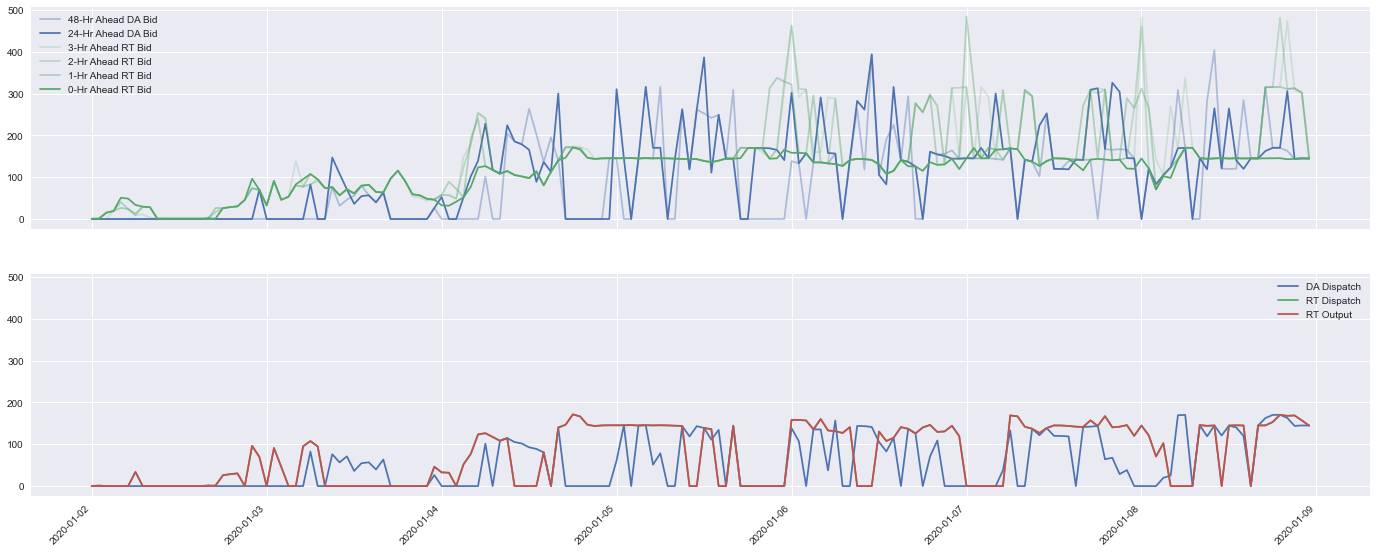

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(24, 10), sharex=True)
ax[0].plot(time_index, np.append([0] * 24, da_bidder_df[da_bidder_df['Horizon [hr]'] >= 24][da_bid_powers].sum(axis=1))[time_slice], color='b', alpha=0.4, label="48-Hr Ahead DA Bid")
ax[0].plot(time_index, da_bidder_df[da_bidder_df['Horizon [hr]'] < 24][da_bid_powers].sum(axis=1)[time_slice], color='b', alpha=1, label="24-Hr Ahead DA Bid")
ax[0].plot(time_index, np.append([0] * 3, rt_bidder_df[rt_bidder_df['Horizon [hr]'] == 3][rt_bid_powers].sum(axis=1))[time_slice], color='g', alpha=0.2, label="3-Hr Ahead RT Bid")
ax[0].plot(time_index, np.append([0] * 2, rt_bidder_df[rt_bidder_df['Horizon [hr]'] == 2][rt_bid_powers].sum(axis=1))[time_slice], color='g', alpha=0.3, label="2-Hr Ahead RT Bid")
ax[0].plot(time_index, np.append([0] * 1, rt_bidder_df[rt_bidder_df['Horizon [hr]'] == 1][rt_bid_powers].sum(axis=1))[time_slice], color='g', alpha=0.4, label="1-Hr Ahead RT Bid")
ax[0].plot(time_index, rt_bidder_df[rt_bidder_df['Horizon [hr]'] == 0]['RT Power 0 [MW]'].values[time_slice], color='g', alpha=1, label="0-Hr Ahead RT Bid")
ax[0].legend()

ax[1].plot(time_index, prescient_df['Dispatch DA'].values[time_slice], color='b', label='DA Dispatch')
ax[1].plot(time_index, prescient_df['Dispatch'].values[time_slice], color='g', label='RT Dispatch')
ax[1].plot(time_index, tracker_df[tracker_df['Horizon [hr]'] == 0][['Power Output [MW]']], color='r', label='RT Output')
ax[1].legend()
ax[1].set_ylim(ax[0].get_ylim())

# need two DA Bids

fig.autofmt_xdate(rotation=45)

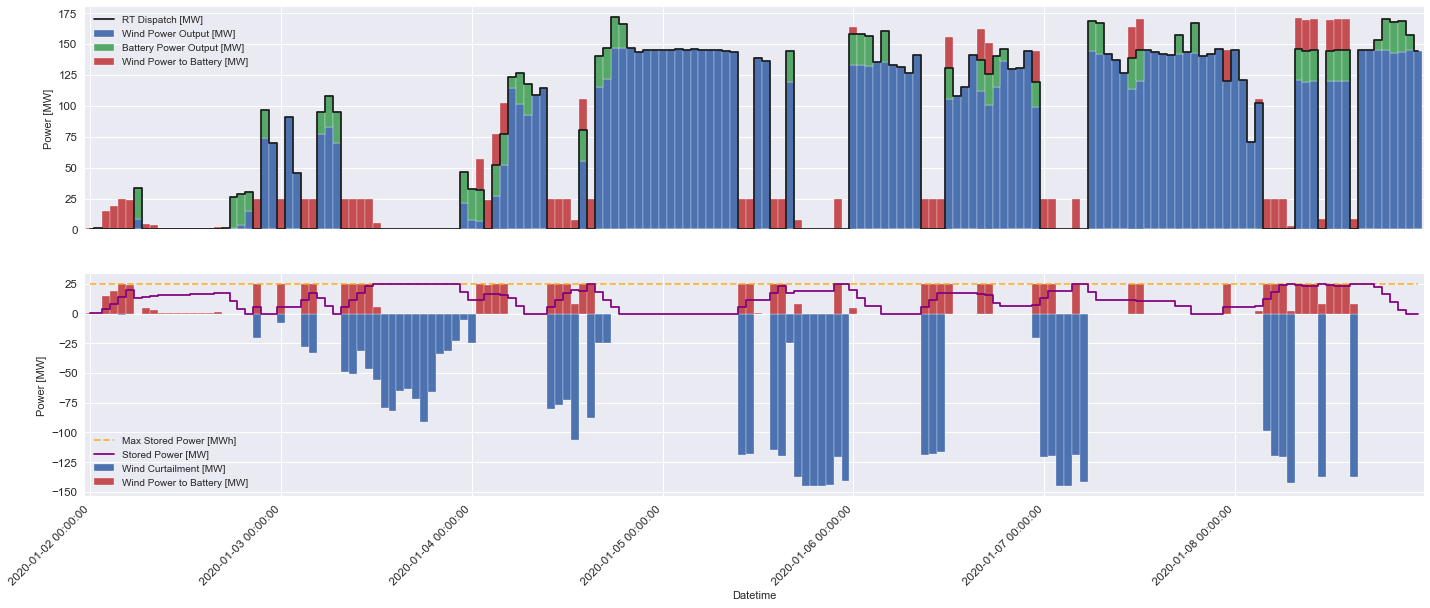

In [63]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(2, 1, figsize=(24,  10), sharex=True)
cols = ["Wind Power Output [MW]", "Battery Power Output [MW]", "Wind Power to Battery [MW]"]
ax[0].plot(tracker_df.loc[tracker_df['Horizon [hr]'] == 0]['Total Power Output [MW]'].values, drawstyle="steps-mid", label='RT Dispatch [MW]', color='k')
tracker_df.loc[tracker_df['Horizon [hr]'] == 0][cols].plot(kind='bar', width=1, stacked=True, ax=ax[0])
ax[0].legend()
ax[0].xaxis.set_minor_locator(MultipleLocator(4))
ax[0].xaxis.set_major_locator(MultipleLocator(24))
ax[0].tick_params(axis='both', which='major', labelsize="small")
ax[0].tick_params(axis='both', which='minor', labelsize="small")
ax[0].set_ylabel("Power [MW]")

tracker_df.loc[tracker_df['Horizon [hr]'] == 0]['Wind Curtailment [MW]'].plot(kind='bar', width=1, stacked=True, ax=ax[1])
tracker_df.loc[tracker_df['Horizon [hr]'] == 0]["Wind Power to Battery [MW]"].plot(kind='bar', width=1, stacked=True, ax=ax[1], color='r')
ax[1].plot([battery_pmax] * len(time_index), linestyle="dashed", label='Max Stored Power [MWh]', alpha=0.8, color='orange')
ax[1].plot(tracker_df.loc[tracker_df['Horizon [hr]'] == 0]['State of Charge [MWh]'].values / 4, drawstyle="steps-mid", label='Stored Power [MW]', color='purple')
ax[1].legend()
ax[1].set_ylabel("Power [MW]")

for i in range(2):
    ax[i].xaxis.set_minor_locator(MultipleLocator(4))
    ax[i].xaxis.set_major_locator(MultipleLocator(24))
    ax[i].tick_params(axis='both', which='major', labelsize="small")
    ax[i].tick_params(axis='both', which='minor', labelsize="small")

fig.autofmt_xdate(rotation=45)

In [58]:
#before and after LMPs and production costs


In [ ]:
prescient_outputs_df
